In [1]:
#necessary libraries
import torch
import torch.nn as nn
from torchvision import transforms
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.io import read_image
from torchvision.utils import save_image
from tqdm import tqdm

In [2]:
import os
folder_path = "/kaggle/input/lego-brick-images/dataset"
png_files = os.listdir(folder_path)
data_map = {}
for idx, file in enumerate(png_files):
    data_map[idx] = file

In [3]:
#parameters
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 1024
Z_DIM = 100
EPOCHS = 200
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1
SAMPLE_INTERVAL = 50

In [4]:
#custom bricks dataset
class BRICKSDataset(Dataset):
    def __init__(self, dataset_path, data_map, transform=None):
        super().__init__()
        self.dataset_path = dataset_path
        self.data_map = data_map
        self.transform = transform
        
    def __len__(self):
        return len(self.data_map)
    
    def __getitem__(self, idx):
        path = self.data_map[idx]
        file_path = os.path.join(self.dataset_path, path)
        image = read_image(file_path)
        if self.transform:
            image = transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0,0.0,0.0], std=[1.0,1.0,1.0]),
])
dataset = BRICKSDataset("/kaggle/input/lego-brick-images/dataset", data_map, transform)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
# dataset[0]

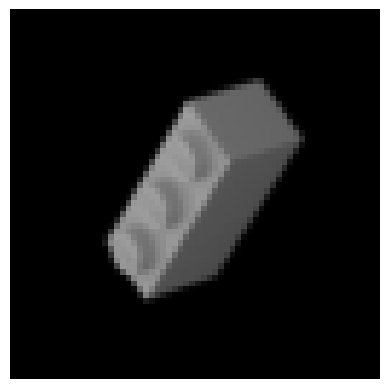

In [6]:
import matplotlib.pyplot as plt
import numpy as np
image = dataset[10]

image = np.transpose(image, (1, 2, 0))

plt.imshow(image)
plt.axis('off')
plt.show()

In [7]:
#defining the generator model
class Discriminator(nn.Module):
    def __init__(self, image_size=64, channels=3):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        x = self.layers(x)
        x = self.flatten(x)
        return x

# discriminator = Discriminator()
# discriminator(dataset[0].unsqueeze(0)).size()

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, channels=3):
        super().__init__()
        self.fc = nn.Linear(z_dim, 1*1*256)
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 1, 1)
        x = self.conv_layers(x)
        return x

# generator = Generator()
# generator(torch.randn((1,100))).size()

In [9]:
# import matplotlib.pyplot as plt
# image = generator(torch.randn((1,100)))
# image = image.squeeze().permute(1,2,0).detach().cpu().numpy()

# plt.imshow(image)
# plt.axis('off')
# plt.show()

In [10]:
# building DCGAN

class DCGAN(nn.Module):
    def __init__(self, generator, discriminator, latent_dim, device):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.loss_fn = nn.BCELoss()
        self.device = device
        
    def compile(self, d_optimizer, g_optimizer):
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        
    def train_step(self, real_images):
        batch_size = real_images.size(0)
        real_labels = torch.ones(batch_size, 1).to(self.device)
        fake_labels = torch.zeros(batch_size, 1).to(self.device)
        
        #train discriminator
        self.d_optimizer.zero_grad()
        random_latent_vectors = torch.randn(batch_size, self.latent_dim).to(device) #[batch_size, 100, 1, 1]
        generated_images = self.generator(random_latent_vectors)
#         print(real_images.device)
        real_predictions = self.discriminator(real_images)
        fake_predictions = self.discriminator(generated_images.detach())
        
        d_real_loss = self.loss_fn(real_predictions, real_labels)
        d_fake_loss = self.loss_fn(fake_predictions, fake_labels)
        d_loss = (d_real_loss + d_fake_loss)/2.0
        d_loss.backward()
        self.d_optimizer.step()
        
        #train generator
        self.g_optimizer.zero_grad()
        fake_predictions = self.discriminator(generated_images)
        
        #we want generated images to be predicted close to 1(real)
        #we want generator to be strong
        g_loss = self.loss_fn(fake_predictions, real_labels)
        g_loss.backward()
        self.g_optimizer.step()
        
        return d_loss.item(), g_loss.item()
    
    def generate_images(self, num_images):
        random_latent_vectors = torch.randn(num_images, self.latent_dim)
        generated_images = self.generator(random_latent_vectors)
        return generated_images

In [11]:
os.makedirs('./models', exist_ok=True)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

#training loop
discriminator = Discriminator().to(device)
generator = Generator().to(device)

dcgan = DCGAN(generator, discriminator, latent_dim=Z_DIM, device=device)
dcgan.to(device)

d_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(ADAM_BETA_1,ADAM_BETA_2))
g_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(ADAM_BETA_1,ADAM_BETA_2))
dcgan.compile(d_optimizer, g_optimizer)

# Move optimizer's state to the same device as the model
for optimizer in [d_optimizer, g_optimizer]:
    for state in optimizer.state.values():
        for key, value in state.items():
            if isinstance(value, torch.Tensor):
                state[key] = value.to(device)

In [12]:
# print(dcgan.generator)

In [13]:
#training loop
for epoch in range(1, EPOCHS):
    d_losses = []
    g_losses = []
    for idx, real_images in enumerate(train_loader):
        input_images = real_images.to(device)  #important line
#         print(real_images.device)
        d_loss, g_loss = dcgan.train_step(input_images)
        d_losses.append(d_loss)
        g_losses.append(g_loss)
    
#     if (epoch) % SAMPLE_INTERVAL == 0:
#         with torch.no_grad():
#             generated_images = dcgan.generate_images(10).cpu()
#             save_image(generated_images, f"./output/generated_img_{epoch}.png", nrow=5, normalize=True)
    
    print(f"Epoch [{epoch}/{EPOCHS}], Discriminator Loss: {torch.mean(torch.tensor(d_losses))}, Generator Loss: {torch.mean(torch.tensor(g_losses))}")
    
    #save at every epoch
    if epoch%10 == 0:
        torch.save(generator.state_dict(), "./models/generator.pth")
        torch.save(discriminator.state_dict(), "./models/discriminator.pth")
        print(f"Model saved for epoch: {epoch}")

Epoch [1/200], Discriminator Loss: 0.12190978229045868, Generator Loss: 7.597405433654785


Epoch [2/200], Discriminator Loss: 0.4068436622619629, Generator Loss: 7.047869682312012


Epoch [3/200], Discriminator Loss: 0.3508804738521576, Generator Loss: 2.565000534057617


Epoch [4/200], Discriminator Loss: 0.23328082263469696, Generator Loss: 3.1905150413513184


Epoch [5/200], Discriminator Loss: 0.2872557044029236, Generator Loss: 3.330364942550659


Epoch [6/200], Discriminator Loss: 0.1684587448835373, Generator Loss: 3.7168991565704346


Epoch [7/200], Discriminator Loss: 0.10491855442523956, Generator Loss: 4.08546781539917


Epoch [8/200], Discriminator Loss: 0.13043293356895447, Generator Loss: 4.33249568939209


Epoch [9/200], Discriminator Loss: 0.13369950652122498, Generator Loss: 5.101870536804199


Epoch [10/200], Discriminator Loss: 0.09172475337982178, Generator Loss: 5.189931392669678
Model saved for epoch: 10


Epoch [11/200], Discriminator Loss: 0.06490086019039154, Generator Loss: 5.052677631378174


Epoch [12/200], Discriminator Loss: 0.0616491362452507, Generator Loss: 5.06304931640625


Epoch [13/200], Discriminator Loss: 0.16165830194950104, Generator Loss: 4.749039649963379


Epoch [14/200], Discriminator Loss: 0.10069884359836578, Generator Loss: 4.5345563888549805


Epoch [15/200], Discriminator Loss: 0.0376911498606205, Generator Loss: 5.473535537719727


Epoch [16/200], Discriminator Loss: 0.24598824977874756, Generator Loss: 3.7494053840637207


Epoch [17/200], Discriminator Loss: 0.11521781980991364, Generator Loss: 4.687252044677734


Epoch [18/200], Discriminator Loss: 0.030832136049866676, Generator Loss: 5.447042465209961


Epoch [19/200], Discriminator Loss: 0.2156059294939041, Generator Loss: 5.600048542022705


Epoch [20/200], Discriminator Loss: 0.1085093766450882, Generator Loss: 5.042123317718506
Model saved for epoch: 20


Epoch [21/200], Discriminator Loss: 0.09425882995128632, Generator Loss: 5.741213321685791


Epoch [22/200], Discriminator Loss: 0.04099634289741516, Generator Loss: 6.058545112609863


Epoch [23/200], Discriminator Loss: 0.027845878154039383, Generator Loss: 6.526533603668213


Epoch [24/200], Discriminator Loss: 0.02271275408565998, Generator Loss: 6.190903186798096


Epoch [25/200], Discriminator Loss: 0.02079043909907341, Generator Loss: 6.30874490737915


Epoch [26/200], Discriminator Loss: 0.09958699345588684, Generator Loss: 5.9066643714904785


Epoch [27/200], Discriminator Loss: 0.03668288514018059, Generator Loss: 7.973437309265137


Epoch [28/200], Discriminator Loss: 0.05209953337907791, Generator Loss: 8.021821975708008


Epoch [29/200], Discriminator Loss: 0.0749741643667221, Generator Loss: 6.950898170471191


Epoch [30/200], Discriminator Loss: 0.05457097291946411, Generator Loss: 6.753839015960693
Model saved for epoch: 30


Epoch [31/200], Discriminator Loss: 0.01968257687985897, Generator Loss: 6.669390678405762


Epoch [32/200], Discriminator Loss: 0.016580786556005478, Generator Loss: 6.984622001647949


Epoch [33/200], Discriminator Loss: 0.01473933644592762, Generator Loss: 7.094964027404785


Epoch [34/200], Discriminator Loss: 0.11290285736322403, Generator Loss: 6.971957206726074


Epoch [35/200], Discriminator Loss: 0.027589192613959312, Generator Loss: 7.230676174163818


Epoch [36/200], Discriminator Loss: 0.029765719547867775, Generator Loss: 6.847442626953125


Epoch [37/200], Discriminator Loss: 0.11101950705051422, Generator Loss: 6.291609764099121


Epoch [38/200], Discriminator Loss: 0.04493524879217148, Generator Loss: 7.104526519775391


Epoch [39/200], Discriminator Loss: 0.139711394906044, Generator Loss: 7.0167646408081055


Epoch [40/200], Discriminator Loss: 0.02671680971980095, Generator Loss: 6.782839775085449
Model saved for epoch: 40


Epoch [41/200], Discriminator Loss: 0.021043220534920692, Generator Loss: 7.481276035308838


Epoch [42/200], Discriminator Loss: 0.018205033615231514, Generator Loss: 7.153611660003662


Epoch [43/200], Discriminator Loss: 0.01040641963481903, Generator Loss: 6.987206935882568


Epoch [44/200], Discriminator Loss: 0.01848132349550724, Generator Loss: 7.101870536804199


Epoch [45/200], Discriminator Loss: 0.016243522986769676, Generator Loss: 7.854485511779785


Epoch [46/200], Discriminator Loss: 0.009249710477888584, Generator Loss: 7.623843193054199


Epoch [47/200], Discriminator Loss: 0.011936302296817303, Generator Loss: 7.594101905822754


Epoch [48/200], Discriminator Loss: 0.1032675951719284, Generator Loss: 7.306584358215332


Epoch [49/200], Discriminator Loss: 0.01852826029062271, Generator Loss: 7.715453147888184


Epoch [50/200], Discriminator Loss: 0.008732706308364868, Generator Loss: 6.919947624206543
Model saved for epoch: 50


Epoch [51/200], Discriminator Loss: 0.008847048506140709, Generator Loss: 6.8257856369018555


Epoch [52/200], Discriminator Loss: 0.029912937432527542, Generator Loss: 7.1540069580078125


Epoch [53/200], Discriminator Loss: 0.019192060455679893, Generator Loss: 7.033216953277588


Epoch [54/200], Discriminator Loss: 0.009333213791251183, Generator Loss: 7.872203826904297


Epoch [55/200], Discriminator Loss: 0.15592801570892334, Generator Loss: 6.3962225914001465


Epoch [56/200], Discriminator Loss: 0.05144248530268669, Generator Loss: 7.236029624938965


Epoch [57/200], Discriminator Loss: 0.018331995233893394, Generator Loss: 6.954639434814453


Epoch [58/200], Discriminator Loss: 0.01241237111389637, Generator Loss: 7.537210941314697


Epoch [59/200], Discriminator Loss: 0.1844058334827423, Generator Loss: 7.15555477142334


Epoch [60/200], Discriminator Loss: 0.14620760083198547, Generator Loss: 6.739367485046387
Model saved for epoch: 60


Epoch [61/200], Discriminator Loss: 0.029838841408491135, Generator Loss: 5.882201671600342


Epoch [62/200], Discriminator Loss: 0.016900939866900444, Generator Loss: 6.383262634277344


Epoch [63/200], Discriminator Loss: 0.01434933952987194, Generator Loss: 7.365390777587891


Epoch [64/200], Discriminator Loss: 0.027213821187615395, Generator Loss: 7.547350883483887


Epoch [65/200], Discriminator Loss: 0.008773664012551308, Generator Loss: 7.191440582275391


Epoch [66/200], Discriminator Loss: 0.008793923072516918, Generator Loss: 7.966638088226318


Epoch [67/200], Discriminator Loss: 0.08379311859607697, Generator Loss: 7.747428894042969


Epoch [68/200], Discriminator Loss: 0.019242161884903908, Generator Loss: 6.711102485656738


Epoch [69/200], Discriminator Loss: 0.012663476169109344, Generator Loss: 7.213951110839844


Epoch [70/200], Discriminator Loss: 0.012910592369735241, Generator Loss: 7.5513916015625
Model saved for epoch: 70


Epoch [71/200], Discriminator Loss: 0.022508865222334862, Generator Loss: 8.057177543640137


Epoch [72/200], Discriminator Loss: 0.02474001608788967, Generator Loss: 7.558327674865723


Epoch [73/200], Discriminator Loss: 0.01626645214855671, Generator Loss: 7.871098518371582


Epoch [74/200], Discriminator Loss: 0.01013163197785616, Generator Loss: 7.88717794418335


Epoch [75/200], Discriminator Loss: 0.007231871131807566, Generator Loss: 7.794778347015381


Epoch [76/200], Discriminator Loss: 0.00934135913848877, Generator Loss: 8.066305160522461


Epoch [77/200], Discriminator Loss: 0.05411561578512192, Generator Loss: 8.143160820007324


Epoch [78/200], Discriminator Loss: 0.07499675452709198, Generator Loss: 7.28420877456665


Epoch [79/200], Discriminator Loss: 0.017756912857294083, Generator Loss: 7.365823268890381


Epoch [80/200], Discriminator Loss: 0.03643638268113136, Generator Loss: 8.661733627319336
Model saved for epoch: 80


Epoch [81/200], Discriminator Loss: 0.012641996145248413, Generator Loss: 8.00049114227295


Epoch [82/200], Discriminator Loss: 0.007761680521070957, Generator Loss: 7.782528877258301


Epoch [83/200], Discriminator Loss: 0.010921109467744827, Generator Loss: 7.614284515380859


Epoch [84/200], Discriminator Loss: 0.007601644843816757, Generator Loss: 7.907242774963379


Epoch [85/200], Discriminator Loss: 0.00980706699192524, Generator Loss: 8.63212776184082


Epoch [86/200], Discriminator Loss: 0.008526870980858803, Generator Loss: 8.809895515441895


Epoch [87/200], Discriminator Loss: 0.007786804344505072, Generator Loss: 9.137590408325195


Epoch [88/200], Discriminator Loss: 0.24701173603534698, Generator Loss: 8.395784378051758


Epoch [89/200], Discriminator Loss: 0.13594567775726318, Generator Loss: 6.049381256103516


Epoch [90/200], Discriminator Loss: 0.044740013778209686, Generator Loss: 5.893397331237793
Model saved for epoch: 90


Epoch [91/200], Discriminator Loss: 0.01418925542384386, Generator Loss: 6.726309776306152


Epoch [92/200], Discriminator Loss: 0.016749918460845947, Generator Loss: 6.897130012512207


Epoch [93/200], Discriminator Loss: 0.013271224685013294, Generator Loss: 7.448678016662598


Epoch [94/200], Discriminator Loss: 0.008412372320890427, Generator Loss: 7.388979911804199


Epoch [95/200], Discriminator Loss: 0.008675756864249706, Generator Loss: 7.322906494140625


Epoch [96/200], Discriminator Loss: 0.006677957717329264, Generator Loss: 7.868607521057129


Epoch [97/200], Discriminator Loss: 0.006739981472492218, Generator Loss: 8.176595687866211


Epoch [98/200], Discriminator Loss: 0.1422145515680313, Generator Loss: 8.083444595336914


Epoch [99/200], Discriminator Loss: 0.23772814869880676, Generator Loss: 5.92061710357666


Epoch [100/200], Discriminator Loss: 0.0844133049249649, Generator Loss: 5.807553291320801
Model saved for epoch: 100


Epoch [101/200], Discriminator Loss: 0.04989872872829437, Generator Loss: 7.010643005371094


Epoch [102/200], Discriminator Loss: 0.01609937660396099, Generator Loss: 6.484803676605225


Epoch [103/200], Discriminator Loss: 0.011331908404827118, Generator Loss: 7.2517805099487305


Epoch [104/200], Discriminator Loss: 0.01266478467732668, Generator Loss: 7.486475944519043


Epoch [105/200], Discriminator Loss: 0.017615094780921936, Generator Loss: 7.6782026290893555


Epoch [106/200], Discriminator Loss: 0.01032913289964199, Generator Loss: 7.796152591705322


Epoch [107/200], Discriminator Loss: 0.0159025676548481, Generator Loss: 7.917877197265625


Epoch [108/200], Discriminator Loss: 0.009293530136346817, Generator Loss: 8.156659126281738


Epoch [109/200], Discriminator Loss: 0.010129171423614025, Generator Loss: 7.7310285568237305


Epoch [110/200], Discriminator Loss: 0.00581988925114274, Generator Loss: 7.707542419433594
Model saved for epoch: 110


Epoch [111/200], Discriminator Loss: 0.004914635326713324, Generator Loss: 7.6791791915893555


Epoch [112/200], Discriminator Loss: 0.007400599308311939, Generator Loss: 8.092554092407227


Epoch [113/200], Discriminator Loss: 0.08398661017417908, Generator Loss: 8.323066711425781


Epoch [114/200], Discriminator Loss: 0.03421185165643692, Generator Loss: 6.77869176864624


Epoch [115/200], Discriminator Loss: 0.013848237693309784, Generator Loss: 6.976296424865723


Epoch [116/200], Discriminator Loss: 0.011782480403780937, Generator Loss: 7.57058048248291


Epoch [117/200], Discriminator Loss: 0.10279929637908936, Generator Loss: 7.022164821624756


Epoch [118/200], Discriminator Loss: 0.019315170124173164, Generator Loss: 8.793343544006348


Epoch [119/200], Discriminator Loss: 0.009256836958229542, Generator Loss: 8.82719612121582


Epoch [120/200], Discriminator Loss: 0.008812593296170235, Generator Loss: 8.257608413696289
Model saved for epoch: 120


Epoch [121/200], Discriminator Loss: 0.005807959008961916, Generator Loss: 8.633012771606445


Epoch [122/200], Discriminator Loss: 0.03376272693276405, Generator Loss: 7.280464172363281


Epoch [123/200], Discriminator Loss: 0.010161095298826694, Generator Loss: 7.903337001800537


Epoch [124/200], Discriminator Loss: 0.009078229777514935, Generator Loss: 8.18484878540039


Epoch [125/200], Discriminator Loss: 0.006283968687057495, Generator Loss: 8.616732597351074


Epoch [126/200], Discriminator Loss: 0.005174827761948109, Generator Loss: 8.568023681640625


Epoch [127/200], Discriminator Loss: 0.007816532626748085, Generator Loss: 8.767253875732422


Epoch [128/200], Discriminator Loss: 0.0055605098605155945, Generator Loss: 8.399734497070312


Epoch [129/200], Discriminator Loss: 0.004509678576141596, Generator Loss: 9.370704650878906


Epoch [130/200], Discriminator Loss: 0.010678858496248722, Generator Loss: 9.941747665405273
Model saved for epoch: 130


Epoch [131/200], Discriminator Loss: 0.01068771444261074, Generator Loss: 9.030121803283691


Epoch [132/200], Discriminator Loss: 0.005898539908230305, Generator Loss: 9.287714004516602


Epoch [133/200], Discriminator Loss: 0.31817227602005005, Generator Loss: 7.654676914215088


Epoch [134/200], Discriminator Loss: 0.24575181305408478, Generator Loss: 6.590400695800781


Epoch [135/200], Discriminator Loss: 0.09978790581226349, Generator Loss: 6.337750434875488


Epoch [136/200], Discriminator Loss: 0.029435981065034866, Generator Loss: 6.102738857269287


Epoch [137/200], Discriminator Loss: 0.015919124707579613, Generator Loss: 6.451517581939697


Epoch [138/200], Discriminator Loss: 0.015785597264766693, Generator Loss: 6.455177307128906


Epoch [139/200], Discriminator Loss: 0.009586798958480358, Generator Loss: 7.020765781402588


Epoch [140/200], Discriminator Loss: 0.009230615571141243, Generator Loss: 7.221535682678223
Model saved for epoch: 140


Epoch [141/200], Discriminator Loss: 0.008553294464945793, Generator Loss: 8.01922607421875


Epoch [142/200], Discriminator Loss: 0.06914953142404556, Generator Loss: 8.07447624206543


Epoch [143/200], Discriminator Loss: 0.020106017589569092, Generator Loss: 7.255614280700684


Epoch [144/200], Discriminator Loss: 0.010008906945586205, Generator Loss: 7.733339786529541


Epoch [145/200], Discriminator Loss: 0.009911669418215752, Generator Loss: 7.726263999938965


Epoch [146/200], Discriminator Loss: 0.008213656023144722, Generator Loss: 8.37839126586914


Epoch [147/200], Discriminator Loss: 0.015501679852604866, Generator Loss: 8.025928497314453


Epoch [148/200], Discriminator Loss: 0.009732834063470364, Generator Loss: 7.9916815757751465


Epoch [149/200], Discriminator Loss: 0.00670734653249383, Generator Loss: 8.409968376159668


Epoch [150/200], Discriminator Loss: 0.03063902258872986, Generator Loss: 8.962931632995605
Model saved for epoch: 150


Epoch [151/200], Discriminator Loss: 0.0076722437515854836, Generator Loss: 8.418392181396484


Epoch [152/200], Discriminator Loss: 0.004869056399911642, Generator Loss: 8.21338176727295


Epoch [153/200], Discriminator Loss: 0.004628708120435476, Generator Loss: 8.531316757202148


Epoch [154/200], Discriminator Loss: 0.02344018779695034, Generator Loss: 8.827056884765625


Epoch [155/200], Discriminator Loss: 0.009946966543793678, Generator Loss: 7.484354496002197


Epoch [156/200], Discriminator Loss: 0.004891286604106426, Generator Loss: 8.359850883483887


Epoch [157/200], Discriminator Loss: 0.0038948100991547108, Generator Loss: 8.861200332641602


Epoch [158/200], Discriminator Loss: 0.003377951681613922, Generator Loss: 9.121339797973633


Epoch [159/200], Discriminator Loss: 0.003603339893743396, Generator Loss: 9.06372356414795


Epoch [160/200], Discriminator Loss: 0.004437932278960943, Generator Loss: 8.427802085876465
Model saved for epoch: 160


Epoch [161/200], Discriminator Loss: 0.0024489127099514008, Generator Loss: 9.185480117797852


Epoch [162/200], Discriminator Loss: 0.002119813347235322, Generator Loss: 9.06432819366455


Epoch [163/200], Discriminator Loss: 0.0014842090895399451, Generator Loss: 9.160123825073242


Epoch [164/200], Discriminator Loss: 0.0016165099805220962, Generator Loss: 9.380638122558594


Epoch [165/200], Discriminator Loss: 0.00119476777035743, Generator Loss: 9.851834297180176


Epoch [166/200], Discriminator Loss: 0.09324027597904205, Generator Loss: 12.454317092895508


Epoch [167/200], Discriminator Loss: 0.09916406869888306, Generator Loss: 9.637815475463867


Epoch [168/200], Discriminator Loss: 0.045610684901475906, Generator Loss: 6.30367374420166


Epoch [169/200], Discriminator Loss: 0.19229060411453247, Generator Loss: 6.607037544250488


Epoch [170/200], Discriminator Loss: 0.24582064151763916, Generator Loss: 6.709753513336182
Model saved for epoch: 170


Epoch [171/200], Discriminator Loss: 0.06331193447113037, Generator Loss: 5.120670318603516


Epoch [172/200], Discriminator Loss: 0.03255871683359146, Generator Loss: 5.227022647857666


Epoch [173/200], Discriminator Loss: 0.02082838863134384, Generator Loss: 5.85113525390625


Epoch [174/200], Discriminator Loss: 0.020356807857751846, Generator Loss: 6.157801151275635


Epoch [175/200], Discriminator Loss: 0.017433302477002144, Generator Loss: 6.717162132263184


Epoch [176/200], Discriminator Loss: 0.014865840785205364, Generator Loss: 6.772411346435547


Epoch [177/200], Discriminator Loss: 0.019352639093995094, Generator Loss: 7.7154388427734375


Epoch [178/200], Discriminator Loss: 0.00795958936214447, Generator Loss: 7.712708950042725


Epoch [179/200], Discriminator Loss: 0.01293250173330307, Generator Loss: 7.749751091003418


Epoch [180/200], Discriminator Loss: 0.023713408038020134, Generator Loss: 8.673591613769531
Model saved for epoch: 180


Epoch [181/200], Discriminator Loss: 0.010790083557367325, Generator Loss: 7.499737739562988


Epoch [182/200], Discriminator Loss: 0.016601702198386192, Generator Loss: 8.20368766784668


Epoch [183/200], Discriminator Loss: 0.009253120981156826, Generator Loss: 7.472699165344238


Epoch [184/200], Discriminator Loss: 0.00718979025259614, Generator Loss: 7.951862335205078


Epoch [185/200], Discriminator Loss: 0.004741915035992861, Generator Loss: 8.903966903686523


Epoch [186/200], Discriminator Loss: 0.0036822110414505005, Generator Loss: 9.544296264648438


Epoch [187/200], Discriminator Loss: 0.004636269062757492, Generator Loss: 8.518031120300293


Epoch [188/200], Discriminator Loss: 0.007793510798364878, Generator Loss: 8.462725639343262


Epoch [189/200], Discriminator Loss: 0.008519185706973076, Generator Loss: 8.739973068237305


Epoch [190/200], Discriminator Loss: 0.004289545584470034, Generator Loss: 9.109926223754883
Model saved for epoch: 190


Epoch [191/200], Discriminator Loss: 0.002910032868385315, Generator Loss: 8.831645011901855


Epoch [192/200], Discriminator Loss: 0.10783274471759796, Generator Loss: 8.306382179260254


Epoch [193/200], Discriminator Loss: 0.28428196907043457, Generator Loss: 6.294951438903809


Epoch [194/200], Discriminator Loss: 0.03258027136325836, Generator Loss: 6.266628265380859


Epoch [195/200], Discriminator Loss: 0.23003831505775452, Generator Loss: 5.552586078643799
